In [238]:
import rsatools as rsa
from floc_selectivity import floc_selectivity
import importlib
import numpy as np
import pandas as pd
import nibabel as nib
import os
from os import listdir
from os.path import isfile, join, exists
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform,cosine,euclidean,mahalanobis
from statsmodels.stats.multitest import multipletests
import scipy.io as sio
import scipy.stats as stats

importlib.reload(rsa)

<module 'rsatools' from '/home/jacobpri/git/RotspaceIT/notebooks/rsatools.py'>

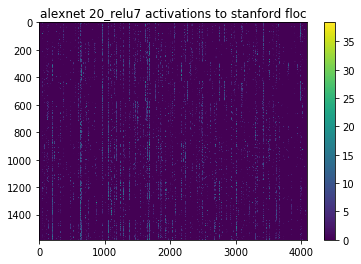

In [208]:
proj_dir = '/home/jacobpri/Exploring-NSD/'
trainset = 'Object'
layer = '20_relu7'
fn_loc = join(proj_dir,'activations/shared1000/AlexNet-' + trainset + '/vpnl_floc/' + layer + '.npy')

# load and reshape if necessary
Y_loc = np.squeeze(np.load(fn_loc))
if np.ndim(Y_loc) == 2:
    Y_loc = Y_loc.T[:,:]
else:
    Y_loc = np.reshape(Y_loc,(Y_loc.shape[0]*Y_loc.shape[1]*Y_loc.shape[2],Y_loc.shape[3])).T[:,:]
    
# visualize
plt.figure()
plt.imshow(Y_loc,aspect='auto')
plt.colorbar()
plt.title('alexnet %s activations to stanford floc' % layer);

In [209]:
floc_categs = np.array(['adult','body','car','child','corridor','house','instrument','limb','number','scrambled','word'])
floc_domains = np.array(['faces','bodies','objects','scenes','characters','scrambled'])
floc_categ_domain_ref = np.array([0,1,2,0,3,3,2,1,4,5,4])
categ_nimg = 144

floc_domain_idx = np.repeat(floc_categ_domain_ref,categ_nimg)

assert(len(floc_domain_idx) == Y_loc.shape[0])
assert(categ_nimg * len(floc_categs) == Y_loc.shape[0])

In [210]:
pref_dict = floc_selectivity(Y_loc, floc_domain_idx)

In [211]:
Y_face = Y_loc[:,pref_dict['domain_idx'][0]]
Y_scene = Y_loc[:,pref_dict['domain_idx'][3]]
print(Y_face.shape, Y_scene.shape)

(1584, 191) (1584, 62)


Text(0.5, 1.0, '12636')

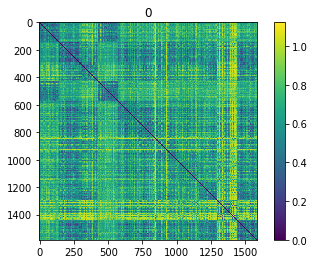

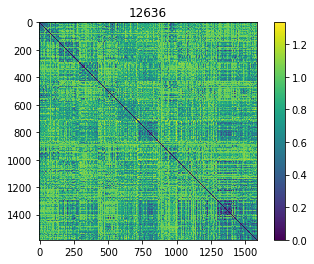

In [221]:
# rdv function: compute rdv from 2d matrix using pearson dissim

Y_face_rdv = rsa.rdv(Y_face)
Y_scene_rdv = rsa.rdv(Y_scene)

plt.figure()
plt.imshow(squareform(Y_face_rdv))
plt.colorbar()
plt.title(np.sum(np.isnan(Y_face_rdv)))
plt.figure()
plt.imshow(squareform(Y_scene_rdv))
plt.colorbar()
plt.title(np.sum(np.isnan(Y_scene_rdv)))

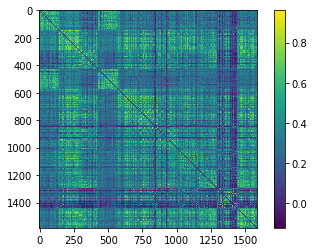

In [218]:
# rsm2rdm function: convert back and forth between similarity and dissimilarity

Y_face_rsm = rsa.rsm2rdm(Y_face_rdv)

plt.imshow(squareform(Y_face_rsm))
plt.colorbar()

In [219]:
# validator functions for rdvcorr
print(rsa.assert_distmat(Y_face)) # should be false
print(rsa.assert_distmat(squareform(Y_face_rdv))) # should be true
print(rsa.assert_distmat(rsa.rsm2rdm(squareform(Y_face_rdv)))) # should also be true


False
True
True


In [220]:
# rdvcorr function: compute correlation between rdvs

# case 1: from data matrices
r = rsa.rdvcorr(Y_face, Y_scene)
print(r)

# case 2: from rdvs
r = rsa.rdvcorr(Y_face_rdv, Y_scene_rdv)
print(r)

# case 3: from rdms
r = rsa.rdvcorr(squareform(Y_face_rdv), squareform(Y_scene_rdv))
print(r)

# case 4: one is data mat, one is rdv
#r = rsa.rdvcorr(Y_face, Y_scene_rdv)
#print(r)

nan


ValueError: nans present in matrix

In [204]:
# correlating rdv from one piece of data with a list of rdvs

# make a list of 4 data sources
neuron_idx = np.array([500, 1500, 2500, 3500])

Y_list = []
for idx in neuron_idx:
    Y_list.append(Y_loc[:,idx:idx+250])
    
print(len(Y_list))
print(Y_list[0].shape)

# pearson corrs
print(rsa.rdvcorr_list(Y_face, Y_list))

# use cosine dist to make the distance matrices now
print(rsa.rdvcorr_list(Y_face, Y_list, dist = 'cosine'))

# use euclidean dist to make the distance matrices now
print(rsa.rdvcorr_list(Y_face, Y_list, dist = 'euclidean'))

4
(1584, 250)


ValueError: input contains nans

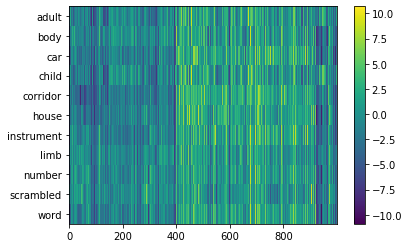

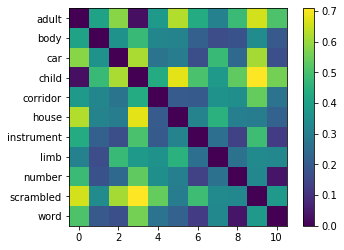

In [205]:
# collapsing item matrix into categ matrix and computing rdm

img_per_categ = 144
categs = np.arange(11)
categ_idx = np.repeat(categs,img_per_categ)

Y_categ = rsa.collapse_categs(Y_loc, categ_idx)

plt.figure()
plt.imshow(Y_categ,aspect='auto')
plt.colorbar()
plt.yticks(np.arange(11),floc_categs);
plt.ylim([10.5,-0.5]);

Y_categ_rdv = rsa.rdv_categ(Y_loc, categ_idx)

plt.figure()
plt.imshow(squareform(Y_categ_rdv))
plt.colorbar()
plt.yticks(np.arange(11),floc_categs);
plt.ylim([10.5,-0.5]);


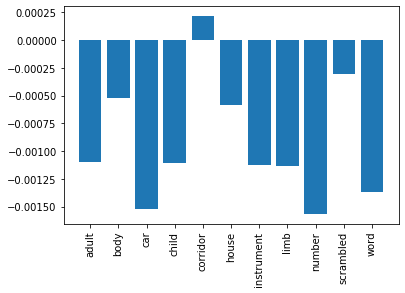

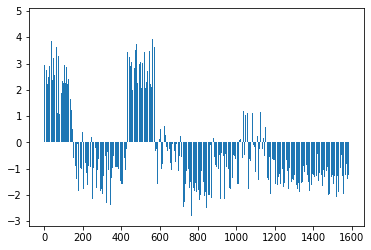

In [206]:
# plot univariate mean activity of each category

Y_categ_univar = rsa.univar_mean(Y_categ)

plt.figure()
plt.bar(np.arange(11),Y_categ_univar)
plt.xticks(np.arange(11),floc_categs,rotation=90);

Y_face_univar = rsa.univar_mean(Y_face)

plt.figure()
plt.bar(np.arange(len(Y_face_univar)),Y_face_univar);

In [207]:
# take average over a list of data
a = [np.ones((4,5)),np.zeros((4,5))]
print(rsa.stack_mean(a))

Y_list_mean = rsa.stack_mean(Y_list)

plt.figure()
plt.imshow(Y_list_mean,aspect='auto')
plt.colorbar()

plt.figure()
plt.imshow(rsa.rdm(Y_list_mean))
plt.colorbar()

plt.figure()
plt.imshow(rsa.rsm(Y_list_mean))
plt.colorbar()


[[0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5]]


ValueError: all input arrays must have the same shape

25272
[[  20]
 [  21]
 [ 448]
 [ 489]
 [1154]
 [1213]
 [1455]
 [1531]]
1584
1576
(1576, 1576)


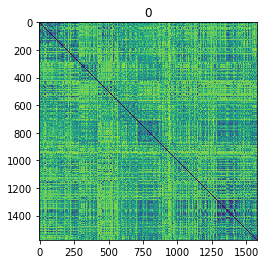

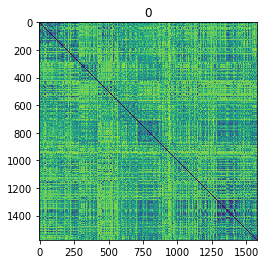

In [239]:
# let's say we have an RDM with nans in it. detect and remove those rows

Y_rdm_wnans = squareform(Y_scene_rdv)
print(rsa.sumnans(Y_rdm_wnans))

nan_rows = np.argwhere(np.isnan(Y_rdm_wnans[0]))
print(nan_rows)

valid_rows = np.setdiff1d(np.arange(Y_rdm_wnans.shape[0]),nan_rows)
print(Y_rdm_wnans.shape[0])
print(len(valid_rows))

Y_rdm_nonans = rsa.subsample_dm(Y_rdm_wnans, valid_rows)

print(Y_rdm_nonans.shape)

plt.figure()
plt.imshow(Y_rdm_nonans)
plt.title(rsa.sumnans(Y_rdm_nonans));

Y_rdm_nonans_ = rsa.remove_dm_nans(Y_rdm_wnans)

plt.figure()
plt.imshow(Y_rdm_nonans_)
plt.title(rsa.sumnans(Y_rdm_nonans_));

0 0
